In [60]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

In [7]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

TensorFlow version: 2.10.1
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
print(tf.test.is_gpu_available())  
print(tf.config.list_physical_devices('GPU'))  
print(tf.test.gpu_device_name()) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('store.csv')

C:\Users\deven\AppData\Local\Temp\ipykernel_6996\3398765028.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


In [10]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [11]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [12]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [13]:
merged_df = train_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [14]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [15]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [17]:
merged_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [18]:
merged_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [19]:
merged_df.Date = pd.to_datetime(merged_df.Date)
merged_test_df.Date = pd.to_datetime(merged_test_df.Date)

<Axes: xlabel='Sales', ylabel='Count'>

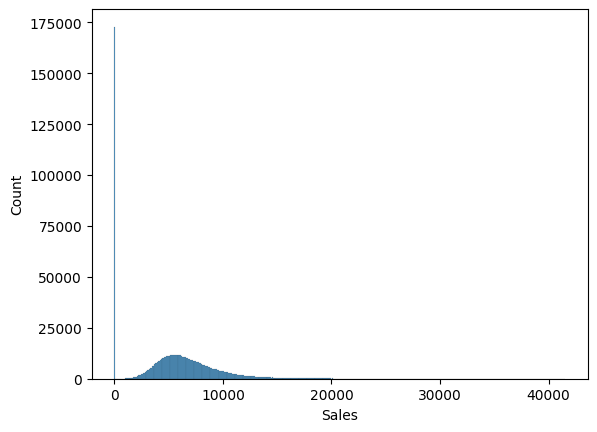

In [20]:
sns.histplot(merged_df.Sales)

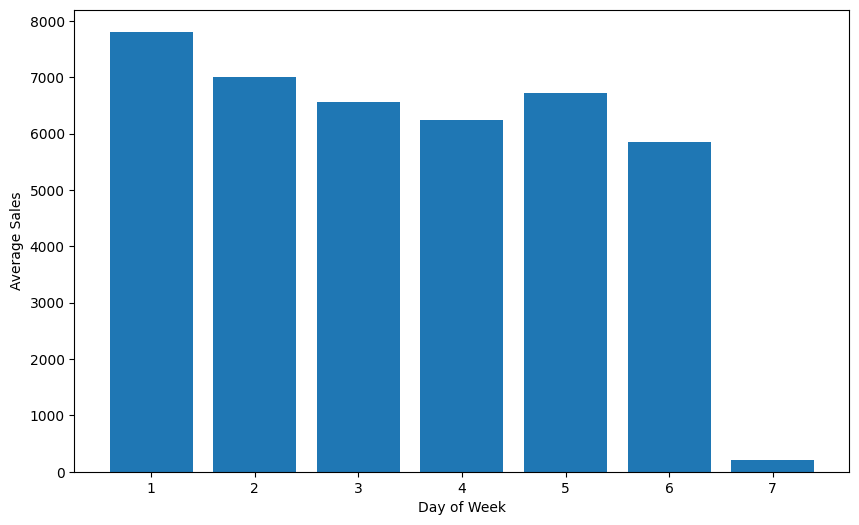

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(merged_df.groupby('DayOfWeek').Sales.mean().index, merged_df.groupby('DayOfWeek').Sales.mean().values)
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

In [22]:
merged_df['Open'].value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

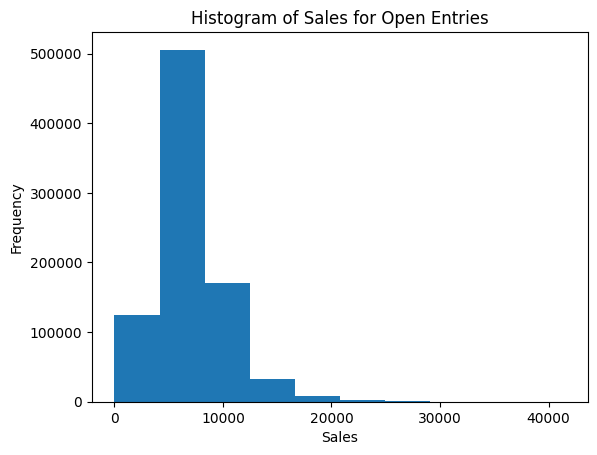

In [23]:
plt.hist(merged_df[merged_df['Open'] == True]['Sales'])  
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Sales for Open Entries')
plt.show()

C:\Users\deven\AppData\Local\Temp\ipykernel_6996\2236914780.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)


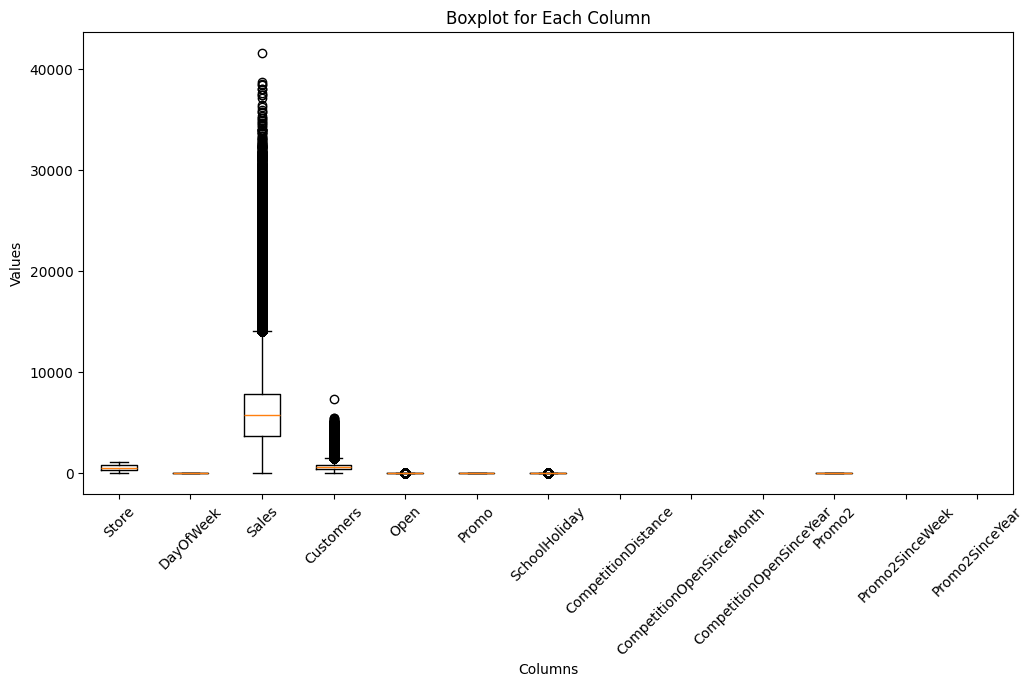

In [24]:
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
plt.xticks(rotation=45) 
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot for Each Column')
plt.show()

In [25]:
Q1 = merged_df['Sales'].quantile(0.25)  
Q3 = merged_df['Sales'].quantile(0.75)  
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_df = merged_df[(merged_df['Sales'] >= lower_bound) & (merged_df['Sales'] <= upper_bound)]

C:\Users\deven\AppData\Local\Temp\ipykernel_6996\2236914780.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)


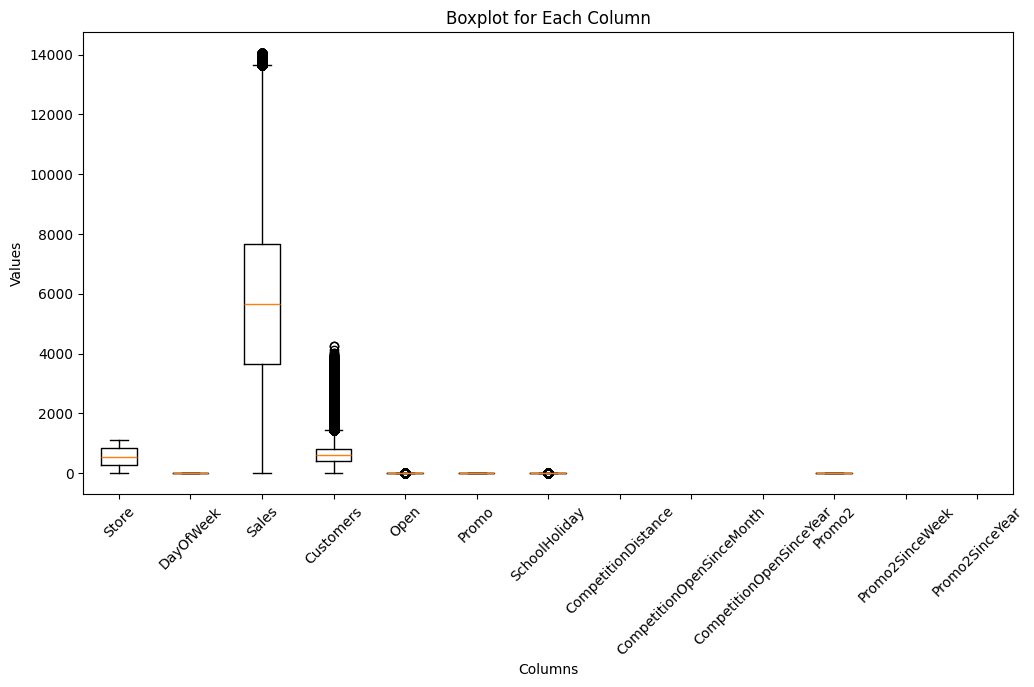

In [26]:
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
plt.xticks(rotation=45) 
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot for Each Column')
plt.show()

In [27]:
Q1 = merged_df['Customers'].quantile(0.25)  
Q3 = merged_df['Customers'].quantile(0.75)  
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_df = merged_df[(merged_df['Customers'] >= lower_bound) & (merged_df['Customers'] <= upper_bound)]

C:\Users\deven\AppData\Local\Temp\ipykernel_6996\2236914780.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)


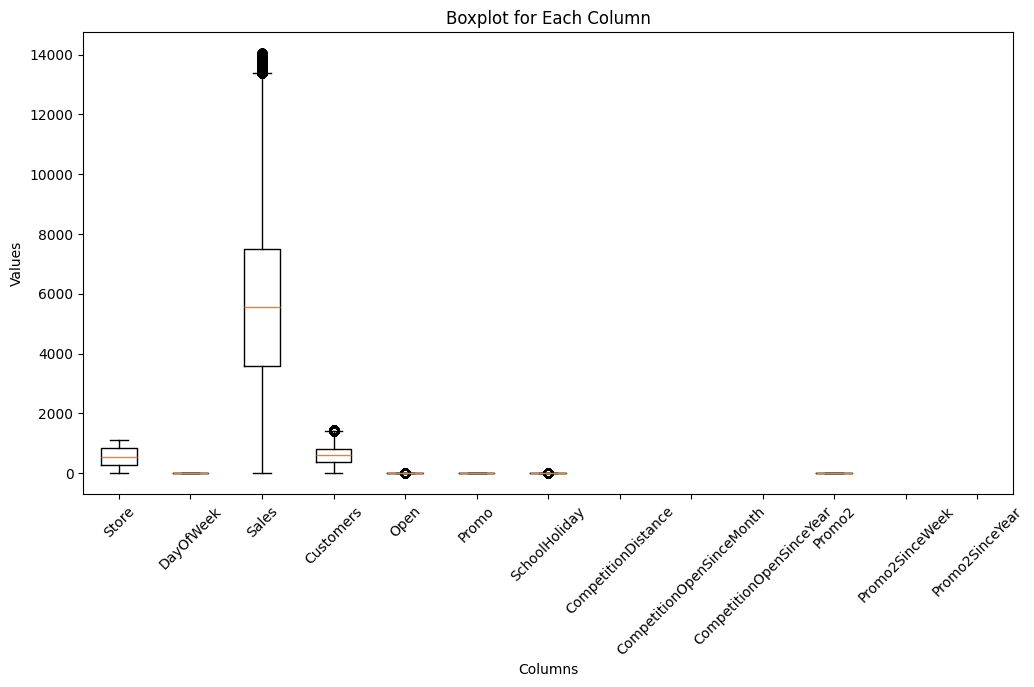

In [28]:
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
plt.xticks(rotation=45) 
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot for Each Column')
plt.show()

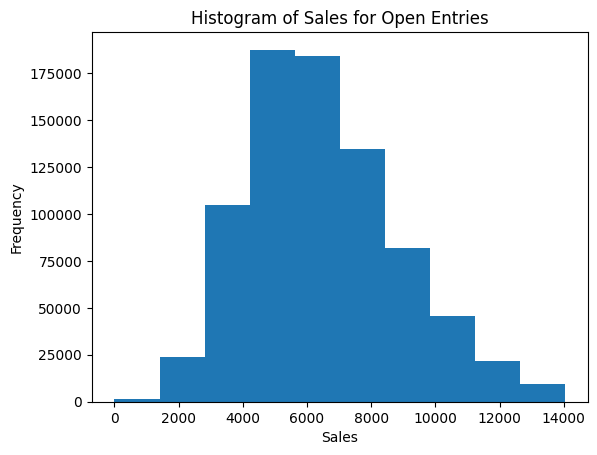

In [29]:
plt.hist(merged_df[merged_df['Open'] == True]['Sales'])  
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Sales for Open Entries')
plt.show()

In [30]:
merged_df['Date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
4         2015-07-31
5         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 967874, dtype: datetime64[ns]

In [31]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Day'] = df['Date'].dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [32]:
split_date(merged_df)
split_date(merged_test_df)

In [33]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
5,6,5,2015-07-31,5651,589,1,1,0,1,a,...,12.0,2013.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [34]:
month_map = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sept": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

def convert_promo_interval(promo_str):
    if pd.isna(promo_str):  
        return ""
    return ",".join(str(month_map[m]) for m in promo_str.split(","))

merged_df['PromoInterval_converted'] = merged_df['PromoInterval'].apply(convert_promo_interval)

In [35]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,PromoInterval_converted
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,"1,4,7,10"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,"1,4,7,10"
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,
5,6,5,2015-07-31,5651,589,1,1,0,1,a,...,2013.0,0,NaN,NaN,NaN,2015,7,31,31,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,"1,4,7,10"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,2006.0,0,NaN,NaN,NaN,2013,1,1,1,
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,0,NaN,NaN,NaN,2013,1,1,1,
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,0,NaN,NaN,NaN,2013,1,1,1,


In [36]:
def check_promo_month(row):
    if pd.isna(row['PromoInterval_converted']) or row['PromoInterval_converted'] == "":
        return 0
    
    # Convert the comma-separated string to a list of integers
    promo_months = list(map(int, row['PromoInterval_converted'].split(',')))
    
    # Check if the Month value is in the list
    return 1 if row['Month'] in promo_months else 0

# Apply the function row-wise
merged_df['IsPromoMonth'] = merged_df.apply(check_promo_month, axis=1)


In [37]:
new_df = merged_df.copy()

In [38]:
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,PromoInterval_converted,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,"1,4,7,10",1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,"1,4,7,10",1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,"1,4,7,10",1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,0,NaN,NaN,NaN,2013,1,1,1,,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,0,NaN,NaN,NaN,2013,1,1,1,,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0,NaN,NaN,NaN,2013,1,1,1,,0


In [39]:
new_df = new_df.drop(['PromoInterval', 'PromoInterval_converted','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'], axis=1)
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,Year,Month,Day,WeekOfYear,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,0,2015,7,31,31,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,1,2015,7,31,31,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,1,2015,7,31,31,1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,0,2015,7,31,31,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,0,2015,7,31,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1,2013,1,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,0,2013,1,1,1,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,0,2013,1,1,1,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,0,2013,1,1,1,0


In [40]:
new_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
StoreType        0
Assortment       0
Promo2           0
Year             0
Month            0
Day              0
WeekOfYear       0
IsPromoMonth     0
dtype: int64

In [41]:
encoder = LabelEncoder()
new_df['StoreType'] = encoder.fit_transform(new_df['StoreType'])

In [42]:
new_df['Assortment'] = encoder.fit_transform(new_df['Assortment'])

In [43]:
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,Year,Month,Day,WeekOfYear,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,0,2015,7,31,31,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,0,1,2015,7,31,31,1
2,3,5,2015-07-31,8314,821,1,1,0,1,0,0,1,2015,7,31,31,1
4,5,5,2015-07-31,4822,559,1,1,0,1,0,0,0,2015,7,31,31,0
5,6,5,2015-07-31,5651,589,1,1,0,1,0,0,0,2015,7,31,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,0,0,1,2013,1,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2,2,0,2013,1,1,1,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,0,2,0,2013,1,1,1,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,0,2,0,2013,1,1,1,0


In [44]:
new_df['StateHoliday'] = new_df['StateHoliday'].astype(str)
new_df['StateHoliday'] = encoder.fit_transform(new_df['StateHoliday'])

In [45]:
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,Year,Month,Day,WeekOfYear,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,0,2015,7,31,31,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,0,1,2015,7,31,31,1
2,3,5,2015-07-31,8314,821,1,1,0,1,0,0,1,2015,7,31,31,1
4,5,5,2015-07-31,4822,559,1,1,0,1,0,0,0,2015,7,31,31,0
5,6,5,2015-07-31,5651,589,1,1,0,1,0,0,0,2015,7,31,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,0,0,1,2013,1,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1,2,2,0,2013,1,1,1,0
1017206,1113,2,2013-01-01,0,0,0,0,1,1,0,2,0,2013,1,1,1,0
1017207,1114,2,2013-01-01,0,0,0,0,1,1,0,2,0,2013,1,1,1,0


In [46]:
df = new_df.copy()

df = df.sort_values(by=["Date"])

features = new_df.drop(['Sales', 'Date'], axis=1).columns.tolist()
target = "Sales"

In [47]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[target] = target_scaler.fit_transform(df[[target]]) 

def create_sequences(data, target_col, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length][features].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(df, target)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Input Shape:", X_train.shape)  

Input Shape: (774275, 30, 15)


In [49]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [52]:
# # Build LSTM Model
# model = Sequential([
#     LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(units=32, return_sequences=False),
#     Dropout(0.2),
#     Dense(units=16, activation="relu"),
#     Dense(units=1)  
# ])
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=False),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])


In [53]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.Huber(delta=50.0),  
              metrics=["mae"])

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 30, 64)            20480     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,497
Trainable params: 34,497
Non-trainable params: 0
_________________________________________________________________


In [54]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,  
    restore_best_weights=True,
    min_delta=0.001 
)

with tf.device('/device:GPU:0'):
    history = model.fit(
        X_train, y_train,
        epochs=100,  
        batch_size=64,  
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=2  
    )

Epoch 1/100
12065/12065 - 228s - loss: 0.0146 - mae: 0.1040 - val_loss: 0.0117 - val_mae: 0.1082 - 228s/epoch - 19ms/step
Epoch 2/100
12065/12065 - 200s - loss: 0.0099 - mae: 0.1011 - val_loss: 0.0096 - val_mae: 0.0987 - 200s/epoch - 17ms/step
Epoch 3/100
12065/12065 - 215s - loss: 0.0093 - mae: 0.0974 - val_loss: 0.0090 - val_mae: 0.0938 - 215s/epoch - 18ms/step
Epoch 4/100
12065/12065 - 215s - loss: 0.0084 - mae: 0.0906 - val_loss: 0.0078 - val_mae: 0.0854 - 215s/epoch - 18ms/step
Epoch 5/100
12065/12065 - 219s - loss: 0.0075 - mae: 0.0840 - val_loss: 0.0075 - val_mae: 0.0823 - 219s/epoch - 18ms/step
Epoch 6/100
12065/12065 - 221s - loss: 0.0070 - mae: 0.0798 - val_loss: 0.0070 - val_mae: 0.0791 - 221s/epoch - 18ms/step
Epoch 7/100
12065/12065 - 221s - loss: 0.0067 - mae: 0.0771 - val_loss: 0.0071 - val_mae: 0.0845 - 221s/epoch - 18ms/step
Epoch 8/100
12065/12065 - 215s - loss: 0.0064 - mae: 0.0750 - val_loss: 0.0069 - val_mae: 0.0775 - 215s/epoch - 18ms/step
Epoch 9/100
12065/12065 

In [55]:
for var in model.trainable_variables:
    print(f"Variable: {var.name}, Device: {var.device}")

Variable: lstm/lstm_cell/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm/lstm_cell/recurrent_kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm/lstm_cell/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_1/lstm_cell_1/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_1/lstm_cell_1/recurrent_kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_1/lstm_cell_1/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_1/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_1/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_2/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_2/bias:0, Device: /job:localhos

In [57]:
model.save("model.h5")

In [4]:
model = load_model("model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            20480     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,497
Trainable params: 34,497
Non-trainable params: 0
_________________________________________________________________


6050/6050 [==============================] - 46s 7ms/step - loss: 0.0061 - mae: 0.0727
Test Loss: 0.0061, Test MAE: 0.0727
6050/6050 [==============================] - 35s 6ms/step


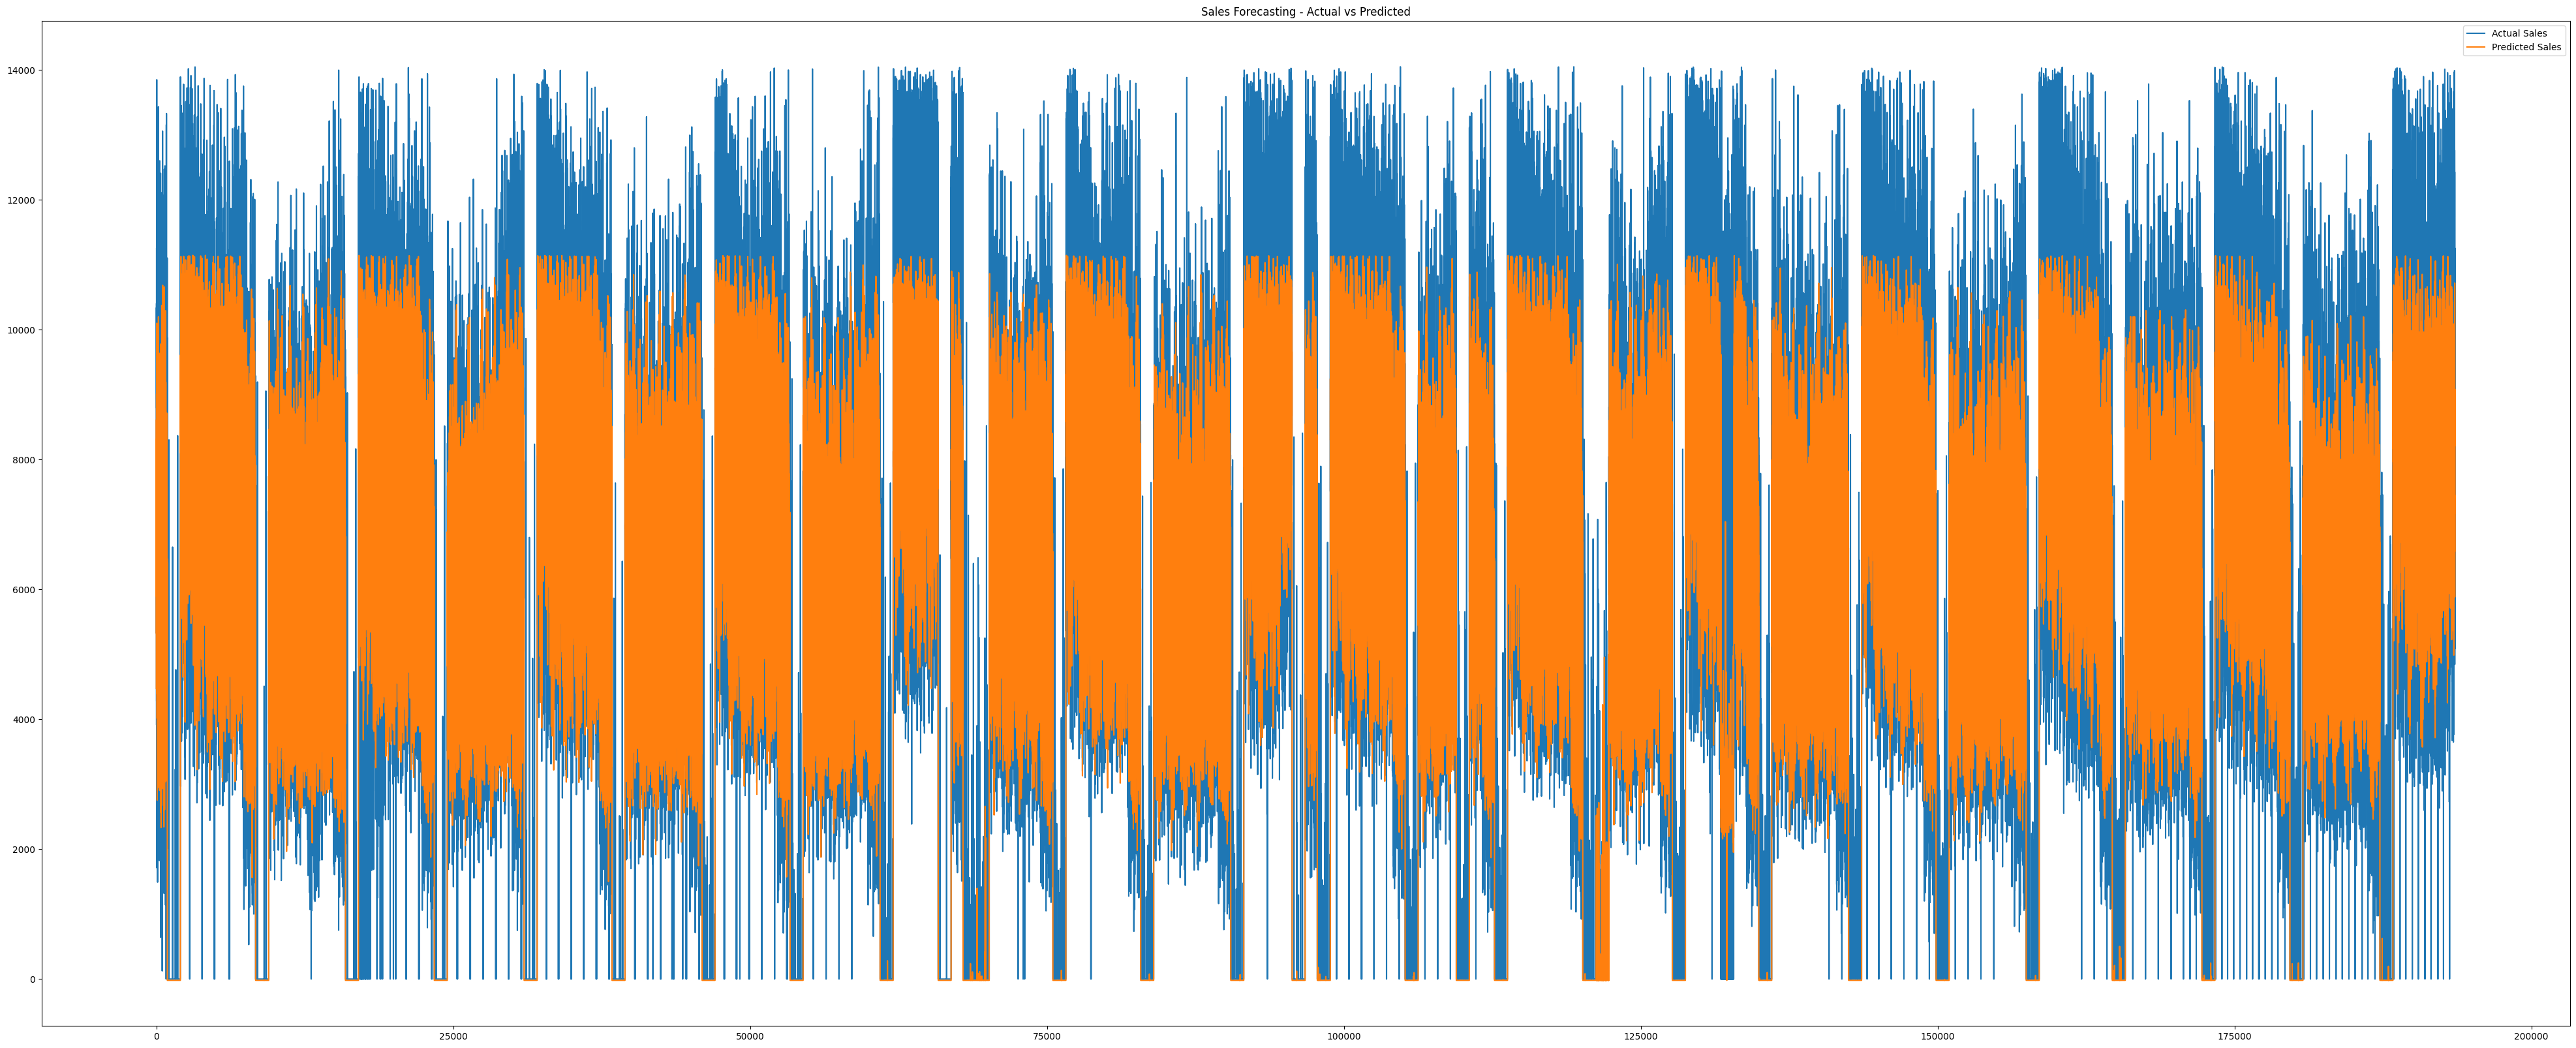

In [50]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Convert predictions back to original scale
y_test_original = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
predictions_original = target_scaler.inverse_transform(predictions)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 20))
plt.plot(y_test_original, label="Actual Sales")
plt.plot(predictions_original, label="Predicted Sales")
plt.legend()
plt.title("Sales Forecasting - Actual vs Predicted")
plt.show()


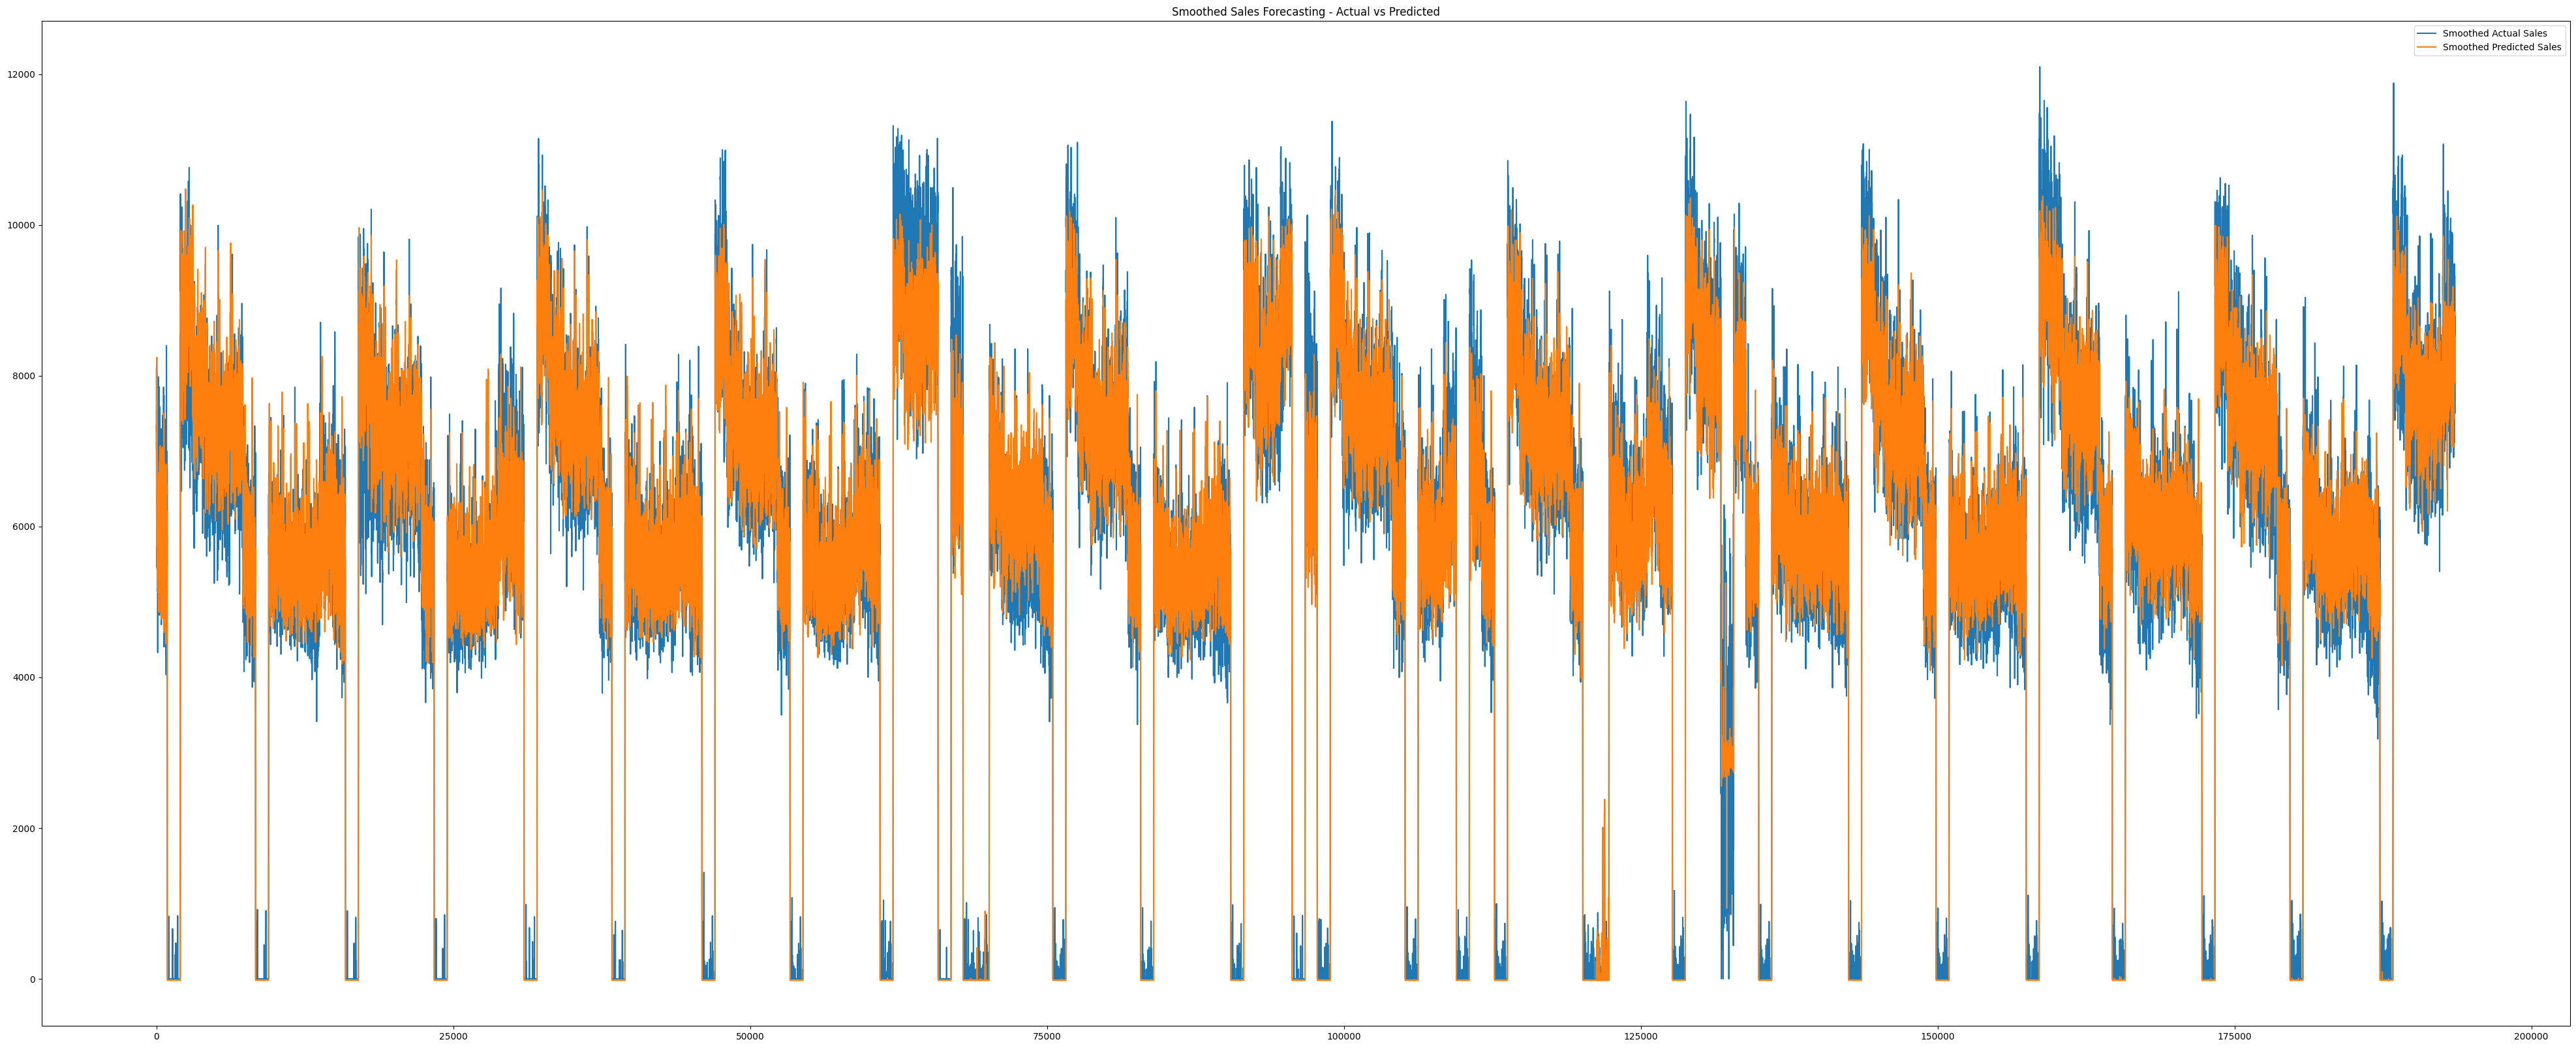

In [51]:
window = 10  # Adjust smoothing level
y_test_smooth = np.convolve(y_test_original.flatten(), np.ones(window)/window, mode='valid')
predictions_smooth = np.convolve(predictions_original.flatten(), np.ones(window)/window, mode='valid')

plt.figure(figsize=(50, 20))
plt.plot(y_test_smooth, label="Smoothed Actual Sales", linestyle="-")
plt.plot(predictions_smooth, label="Smoothed Predicted Sales", linestyle="-")
plt.legend()
plt.title("Smoothed Sales Forecasting - Actual vs Predicted")
plt.show()

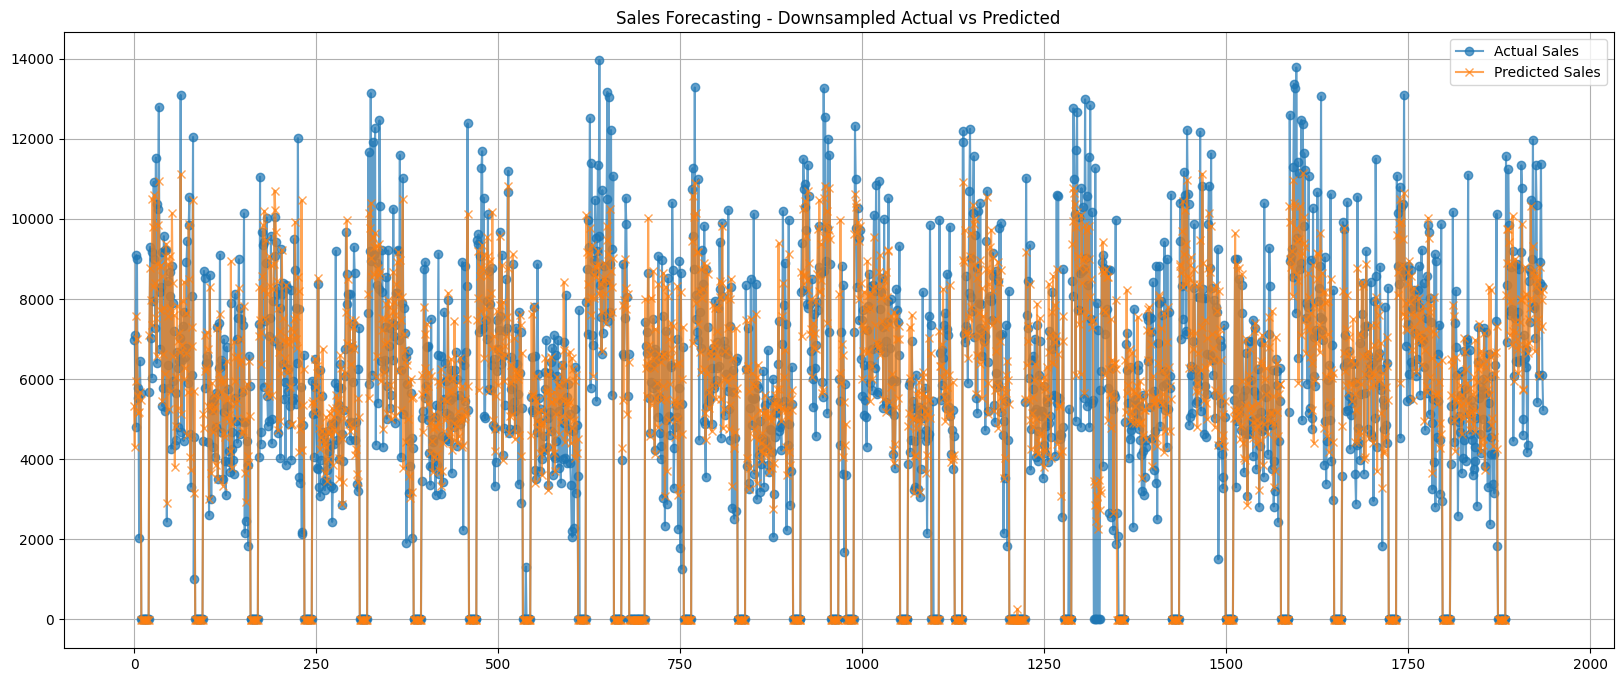

In [52]:
step = 100  # Adjust based on dataset size
plt.figure(figsize=(20, 8))
plt.plot(y_test_original[::step], label="Actual Sales", linestyle="-", marker="o", alpha=0.7)
plt.plot(predictions_original[::step], label="Predicted Sales", linestyle="-", marker="x", alpha=0.7)
plt.legend()
plt.title("Sales Forecasting - Downsampled Actual vs Predicted")
plt.grid(True)
plt.show()


In [56]:
def evaluate_model(y_true, y_pred, step=100):
    indices = np.arange(0, len(y_true), step)
    y_true_sampled = y_true[indices]
    y_pred_sampled = y_pred[indices]
    
    rmse = mean_squared_error(y_true_sampled, y_pred_sampled) ** 0.5 
    mae = mean_absolute_error(y_true_sampled, y_pred_sampled)
    r2 = r2_score(y_true_sampled, y_pred_sampled)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'R² Score: {r2:.4f}')

evaluate_model(y_test_original, predictions_original, step=100)

RMSE: 1406.22
MAE: 951.62
R² Score: 0.8153


In [62]:
def objective(trial):
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    dense_units_1 = trial.suggest_categorical("dense_units_1", [16, 32, 64])
    dense_units_2 = trial.suggest_categorical("dense_units_2", [8, 16, 32])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 10, 100)

    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units_1, activation='relu', kernel_regularizer='l2'),
        Dense(dense_units_2, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=Huber(delta=50.0), metrics=["mae"])

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train, y_train, 
                            validation_data=(X_test, y_test),  
                            batch_size=batch_size, 
                            epochs=epochs, 
                            verbose=0, 
                            callbacks=[early_stopping])

    val_mae = min(history.history["val_mae"])

    return val_mae

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best hyperparameters:", study.best_params)


[I 2025-03-06 16:05:13,338] A new study created in memory with name: no-name-f8c68fb0-ab91-48ed-b6e0-f77e1a064245
[W 2025-03-06 16:05:22,288] Trial 0 failed with parameters: {'lstm_units': 256, 'dropout_rate': 0.18960003040219275, 'dense_units_1': 32, 'dense_units_2': 16, 'learning_rate': 0.00012376422178321316, 'batch_size': 16, 'epochs': 88} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Main_Python\.venv310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\deven\AppData\Local\Temp\ipykernel_6996\72309238.py", line 25, in objective
    history = model.fit(X_train, y_train,
  File "d:\Main_Python\.venv310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "d:\Main_Python\.venv310\lib\site-packages\keras\engine\training.py", line 1564, in fit
    tmp_logs = self.train_function(iterator)
  File "d:\Main

KeyboardInterrupt: 